## Environment Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from PIL import Image
import os
import cv2
from skimage import color
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD

## Preprocessing

In [ ]:
def guided_filter(I, p, r, eps):
    I = I.astype(np.float32)
    p = p.astype(np.float32)

    mean_I = cv2.boxFilter(I, cv2.CV_32F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F, (r, r))
    mean_Ip = cv2.boxFilter(I * p, cv2.CV_32F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(I * I, cv2.CV_32F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_32F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F, (r, r))

    q = mean_a * I + mean_b
    return q

In [ ]:
def apply_guided_filter(image, r=15, eps=1e-2):
    I = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered_image = guided_filter(I, I, r, eps)
    return cv2.merge([filtered_image, filtered_image, filtered_image])

In [ ]:
def convert_to_lab(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    return lab_image

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    filtered_image = apply_guided_filter(image)
    lab_image = convert_to_lab(filtered_image)
    return lab_image

In [ ]:
label_mapping = {
    'whitehead': 0,
    'papula_pustula': 1,
    'milia': 2,
    'blackhead': 3,
    'acne_nodules': 4
}

In [ ]:
def preprocess_and_augment_data(image_dir, img_size=(224, 224), num_classes=5, label_mapping=None):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255,
    )
    images = []
    labels = []
    for folder in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                preprocessed_image = preprocess_image(file_path)
                resized_image = cv2.resize(preprocessed_image, img_size)
                images.append(resized_image)
                labels.append(label_mapping[folder])  # Use the mapping to convert folder names to integers
    images = np.array(images)
    labels = to_categorical(np.array(labels), num_classes=num_classes)  # One-hot encoding labels
    datagen.fit(images)
    return datagen, images, labels

In [ ]:
from PIL import Image
import os

def check_images(s_dir, ext_list):
    bad_images = []
    for fldr in os.listdir(s_dir):
        sub_folder = os.path.join(s_dir, fldr)
        if os.path.isdir(sub_folder):
            for file in os.listdir(sub_folder):
                file_path = os.path.join(sub_folder, file)
                if os.path.splitext(file_path)[1].lower() not in ext_list:
                    continue
                try:
                    img = Image.open(file_path)  # open the image file
                    img.verify()  # verify that it is, in fact, an image
                except (IOError, SyntaxError) as e:
                    print('Bad file:', file_path)  # print out the names of corrupt files
                    bad_images.append(file_path)
    return bad_images

bad_files = check_images('/content/drive/My Drive/Acnetify/DATASET_CLEANING/Training_awal', ['.jpg', '.jpeg', '.png'])
print('Found bad files:', bad_files)

Found bad files: []


In [ ]:
base_dir = '/content/drive/My Drive/Acnetify/DATASET_CLEANING/'
train_dir = base_dir + 'Training_resize'
val_dir = base_dir + 'Val_resize'
test_dir = base_dir + 'Test_crop'

# train_datagen, X_data, y_data = preprocess_and_augment_data(train_dir, label_mapping=label_mapping)

train_datagen, X_train, y_train = preprocess_and_augment_data(train_dir, label_mapping=label_mapping)
val_datagen, X_val, y_val = preprocess_and_augment_data(val_dir, label_mapping=label_mapping)
test_datagen, X_test, y_test = preprocess_and_augment_data(test_dir, label_mapping=label_mapping)
# X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)


# train_generator = train_datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
# validation_generator = train_datagen.flow(X_val, y_val, batch_size=64, shuffle=False)

## Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, roc_curve, auc

def train_and_evaluate_model(model, train_gen, val_gen, epochs=50):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(train_gen,
                        epochs=epochs,
                        validation_data=val_gen,
                        steps_per_epoch=len(train_gen),
                        validation_steps=len(val_gen),
                        callbacks=[reduce_lr, early_stopping])

    return history

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNet
def build_model(input_shape=(224, 224, 3), num_classes=5):
  X_input = Input(input_shape)

  # Conv Block 1
  X = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 2), strides=(2, 2))(X)

  # Conv Block 2
  X = Conv2D(48, (3, 3), strides=(2, 2), padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # Conv Block 3
  X = Conv2D(32, (3, 3), padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 2), strides=(2, 2))(X)

  # Conv Block 4
  X = Conv2D(16, (3, 3), padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  # Top Layers
  X = Flatten()(X)
  X = Dense(512, activation='relu')(X)
  X = Dense(256, activation='relu')(X)
  X = Dense(128, activation='relu')(X)
  X = Dense(num_classes, activation='softmax')(X)

  model = Model(inputs=X_input, outputs=X, name='ModelNet')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
model = build_model(input_shape=(224, 224, 3), num_classes=5)
model.summary()

Model: "ModelNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      1792      
                                                                 
 batch_normalization_12 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 48)        276

## Training & Evaluation

In [ ]:
# splitting_schemes = [(0.8, 0.2), (0.7, 0.3), (0.6, 0.4), (0.5, 0.5)]
# batch_sizes = [8, 16, 32, 64]
# epochs_schemes = [10, 20, 30, 40, 50]

splitting_schemes = [(0.9, 0.1)]
batch_sizes = [32]
epochs_schemes = [100]

In [ ]:
X_data.shape, y_data.shape

((500, 224, 224, 3), (500, 5))

In [ ]:
results = []
for split in splitting_schemes:
    # X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=split[1], random_state=42)

    for batch_size in batch_sizes:
        for epochs in epochs_schemes:
            model = build_model(input_shape=(224, 224, 3), num_classes=5)
            history = train_and_evaluate_model(model,
                                               train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
                                               train_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=True),
                                               epochs=epochs)

            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            results.append({
                'split': split,
                'batch_size': batch_size,
                'epochs': epochs,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            })

Epoch 1/100
94/94 [==============================] - 39s 385ms/step - loss: 1.6457 - accuracy: 0.2143 - val_loss: 1.6136 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 2/100
94/94 [==============================] - 36s 382ms/step - loss: 1.6209 - accuracy: 0.2190 - val_loss: 1.6118 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/100
94/94 [==============================] - 36s 385ms/step - loss: 1.6139 - accuracy: 0.2107 - val_loss: 1.6104 - val_accuracy: 0.2050 - lr: 1.0000e-04
Epoch 4/100
94/94 [==============================] - 37s 389ms/step - loss: 1.6080 - accuracy: 0.2233 - val_loss: 1.6115 - val_accuracy: 0.2050 - lr: 1.0000e-04
Epoch 5/100
94/94 [==============================] - 36s 384ms/step - loss: 1.6077 - accuracy: 0.2333 - val_loss: 1.6155 - val_accuracy: 0.1967 - lr: 1.0000e-04
Epoch 6/100
94/94 [==============================] - 36s 382ms/step - loss: 1.6049 - accuracy: 0.2223 - val_loss: 1.6173 - val_accuracy: 0.1983 - lr: 1.0000e-04
Epoch 7/100
94/94 [===============

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df

,split,batch_size,epochs,val_loss,val_accuracy
0,"(0.9, 0.1)",32,100,17.206078,0.208333


## Evaluation

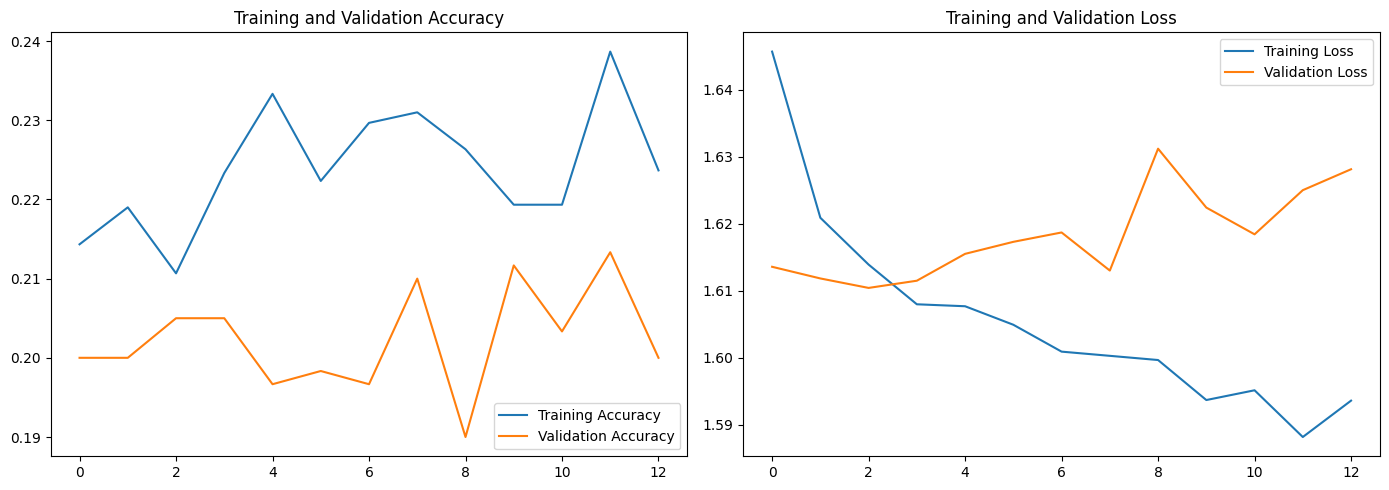

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation Metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes))

19/19 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.27      0.09      0.14       120
           1       0.21      0.94      0.34       120
           2       0.00      0.00      0.00       120
           3       0.11      0.01      0.02       120
           4       0.00      0.00      0.00       120

    accuracy                           0.21       600
   macro avg       0.12      0.21      0.10       600
weighted avg       0.12      0.21      0.10       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


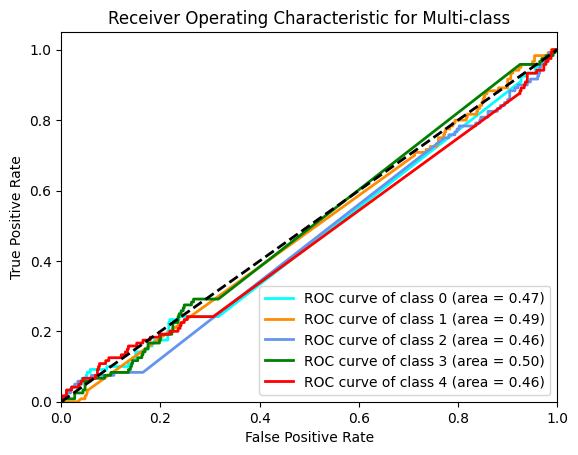

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the output
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()

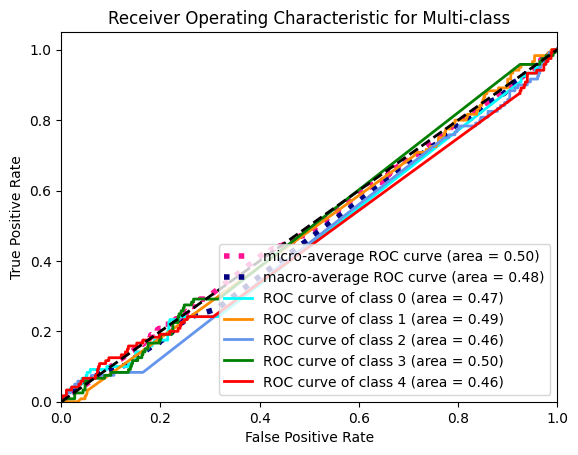

In [ ]:
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
# Precision and Recall
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Precision: 0.11697166789849715
Recall: 0.20833333333333334
ROC AUC: 0.47538888888888886


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Specificity Calculation
conf_matrix = confusion_matrix(y_true, y_pred_classes)
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TP = conf_matrix[1][1]
specificity = TN / (TN + FP)
print(f"Specificity: {specificity}")

Specificity: 0.09322033898305085


## Evaluation Metrics on Test Data

## Comparation with Other Models

In [ ]:
pretrained_models = [VGG16, ResNet50, InceptionV3, MobileNet]

In [ ]:
for base_model in pretrained_models:
    model = pretrained_model(base_model)
    history = train_and_evaluate_model(model,
                                       train_datagen.flow(X_train, y_train, batch_size=32),
                                       test_datagen.flow(X_val, y_val, batch_size=32),
                                       epochs=10)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"{base_model.__name__} - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

NameError: name 'pretrained_model' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7bff57b2-cd1b-4d31-87b2-4f5483361437' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>